In [38]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv(r'events_log.csv')
data.timestamp = data.timestamp.apply(lambda x: datetime.datetime.utcfromtimestamp(int(x/1000)))

In [3]:
data['day'] = data.timestamp.apply(lambda x: pd.datetime.date(x).day)
data['month'] = data.timestamp.apply(lambda x: pd.datetime.date(x).month)

In [4]:
data.head(5)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day,month
0,00000736167c507e8ec225bd9e71f9e5,2608-11-08 19:38:23,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,8,11
1,00000c69fe345268935463abbfa5d5b3,2608-11-08 21:16:45,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,8,11
2,00003bfdab715ee59077a3670331b787,2608-11-08 19:55:45,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,8,11
3,0000465cd7c35ad2bdeafec953e08c1a,2608-11-08 19:57:02,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,8,11
4,000050cbb4ef5b42b16c4d2cf69e6358,2608-11-08 19:54:55,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,8,11


In [5]:
data.nunique()

uuid               400165
timestamp            1131
session_id          68028
group                   2
action                  3
checkin                15
page_id            176371
n_results              92
result_position       193
day                     1
month                   1
dtype: int64

## What is their daily overall clickthrough rate? How does it vary between the groups?


This data contain only one day user activity. So, I guess I have to find for that day only. For Overall clickthrough rate I am sampling data where the search results have some count as if there are no search result than user have nothing to click on.

Overall clickthrough rate:

In [8]:
sessionids = data[(data.action == 'searchResultPage') & (~data.n_results.isna())].session_id.values
clickthroughdata = data[data.session_id.isin(sessionids)]

usercountwhoclicked = sum(clickthroughdata.groupby(['session_id'])['checkin'].count() > 0)
totalusers = len(clickthroughdata.groupby(['session_id'])['checkin'].count())

In [7]:
print("Overall clickthrough rate :", usercountwhoclicked/totalusers)

Overall clickthrough rate : 0.3417462583332107


variation between groups:

In [10]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

In [11]:
A_usercountwhoclicked = sum(A.groupby(['session_id'])['checkin'].count() > 0)
A_totalusers = len(A.groupby(['session_id'])['checkin'].count())

B_usercountwhoclicked = sum(B.groupby(['session_id'])['checkin'].count() > 0)
B_totalusers = len(B.groupby(['session_id'])['checkin'].count())

In [12]:
print("Overall clickthrough rate for group(a) user:", A_usercountwhoclicked/A_totalusers)

print("Overall clickthrough rate for group(b) user:", B_usercountwhoclicked/B_totalusers)

Overall clickthrough rate for group(a) user: 0.5940176750509857
Overall clickthrough rate for group(b) user: 0.14912667722093897


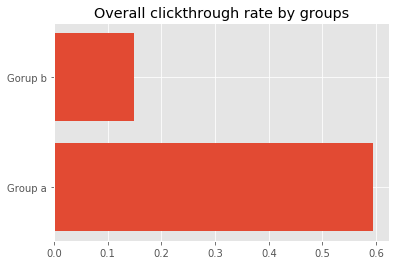

In [39]:
plt.barh(range(2),[.594,.1491])
plt.yticks(range(2),['Group a','Gorup b'])
plt.val
plt.title('Overall clickthrough rate by groups')
plt.show()